In [1]:
import numpy as np
import math
import random
seed = 666
random.seed(seed)
np.random.seed(seed)
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

from clusterless import preprocess

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016'

In [3]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)
static_behaviors = {'choice': choices, 'stimulus': one_hot_stimuli}

choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


In [4]:
rois = [roi.lower() for roi in ['PO', 'LP', 'DG', 'CA1', 'VIS']]

In [5]:
roi = rois[-1]
print(roi)

vis


In [6]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24
found 29 neurons in region vis ...
found 28 channels in region vis ...


In [7]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

rand_idx = np.arange(n_trials)
train_idx = rand_idx[:int(.8*n_trials)]
test_idx = rand_idx[int(.8*n_trials):]

train_features = np.vstack([unsorted_trials[i][:,2:] for i in train_idx])
train_y = choices[train_idx].argmax(1)
test_y = choices[test_idx].argmax(1)

In [80]:
n_time_bins = 15
binning = np.arange(0, 1.5, step=(1.5 - 0)/n_time_bins)
n_trials = stim_on_times.shape[0]
spike_train = np.concatenate(unsorted_trials)[:,[0,2,3,4]]

In [81]:
trial_idx = []
time_idx = []
all_trials = []
for k in range(n_trials):
    mask = np.logical_and(spike_train[:,0] >= stim_on_times[k]-0.5,
                          spike_train[:,0] <= stim_on_times[k]+1
                         )
    trial = spike_train[mask,:]
    trial[:,0] = trial[:,0] - trial[:,0].min()
    time_bins = np.digitize(trial[:,0], binning, right=False)-1
    for t in range(n_time_bins):
        time_bin = trial[time_bins == t, 1:]
        time_idx.append(np.ones_like(time_bin[:,0]) * t)
        trial_idx.append(np.ones_like(time_bin[:,0]) * k)
        all_trials.append(time_bin)
time_idx = np.concatenate(time_idx)
trial_idx = np.concatenate(trial_idx)
all_trials = np.concatenate(all_trials)

In [82]:
train_mask = np.sum([trial_idx == idx for idx in train_idx], axis=0).astype(bool)
train_trials = all_trials[train_mask]
train_time_idx = time_idx[train_mask]
train_trial_idx = trial_idx[train_mask]

In [83]:
test_mask = np.sum([trial_idx == idx for idx in test_idx], axis=0).astype(bool)
test_trials = all_trials[test_mask]
test_time_idx = time_idx[test_mask]
test_trial_idx = trial_idx[test_mask]

In [46]:
C = 25
gmm = GaussianMixture(n_components=C, 
                      covariance_type='full', 
                      init_params='k-means++',
                      verbose=1)
gmm.fit(train_trials)
means = gmm.means_
covs = gmm.covariances_

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


In [47]:
gmm.means_.shape

(25, 3)

In [84]:
lambdas = []

for k in train_idx:
    mask = np.logical_and(spike_train[:,0] >= stim_on_times[k]-0.5,
                          spike_train[:,0] <= stim_on_times[k]+1
                         )
    trial = spike_train[mask,:]
    trial[:,0] = trial[:,0] - trial[:,0].min()
    time_bins = np.digitize(trial[:,0], binning, right=False)-1
    time_bins_lst = []
    for t in range(n_time_bins):
        time_bin = trial[time_bins == t, 1:]
        probs_array = np.zeros((C, 2))
        if len(time_bin) != 0:
            cluster_idx = gmm.predict(time_bin)
            probs = gmm.predict_proba(time_bin)
            for j in range(C):
                if choices[k].argmax() == 0:
                    probs_array[j, 0] = np.sum(probs[cluster_idx == j])
                else:
                    probs_array[j, 1] = np.sum(probs[cluster_idx == j])
        else:
            print('found empty time bin.')
        time_bins_lst.append(probs_array)
    lambdas.append(time_bins_lst)
lambdas = np.array(lambdas)

found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.
found empty time bin.


In [85]:
n_left = np.sum(train_y==0)
n_right = np.sum(train_y==1)
lams = lambdas.sum(0) / np.array([n_left, n_right])
lams = lams.transpose(1,0,2)
diff_lams = lams[:,:,0] - lams[:,:,1]

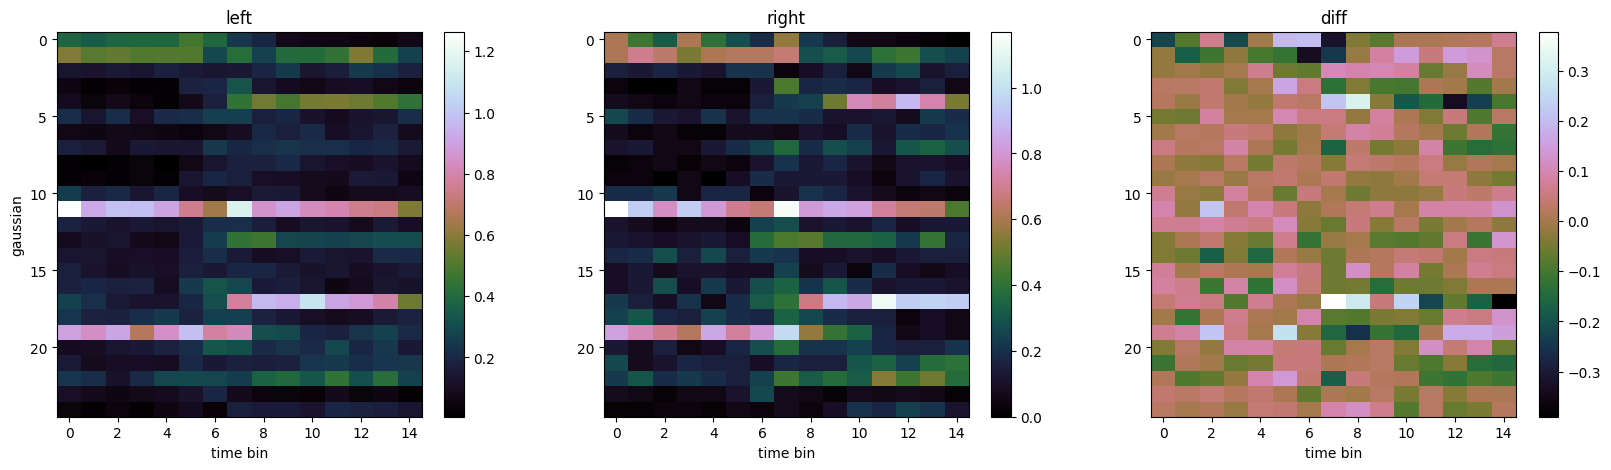

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(lams[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title('left')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(lams[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title('right')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(diff_lams, aspect='auto', cmap='cubehelix')
ax3.set_title('diff')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

In [51]:
def safe_log(x, minval=1e-10):
    return np.log(x + minval)

def safe_divide(x, y):
    return np.clip(x / y, a_min=0, a_max=1)

In [52]:
def compute_elbo_enc(s, y, y_k, r, r_kt, mu, cov, lam, ks, ts):

    K = np.unique(ks).shape[0]
    T = np.unique(ts).shape[0]
    C = mu.shape[0]
    
    # expected log-likelihood ( E_q(z)[log p(s,z|y)] )
    # sum_{ktij} r_{ijt}^k * log(dN(s_i^kt; mu_j, cov_j))
    
    # sum_{ktij} r_{ijt}^k * ( y^k * (log(lambda^t_{j1}) - log(sum_j' lambda^t_{j'1})) 
    #                    + (1-y^k) * (log(lambda^t_{j0}) - log(sum_j' lambda^t_{j'0})) )
    log_dens = np.transpose(
                        [multivariate_normal.logpdf(s, mu[j], cov[j]) \
                         for j in range(C)]
                        )
    elbo_1 = np.sum( r * log_dens )
    
    elbo_2 = 0
    for k in range(K):
        for t in range(T):
            elbo_2 += np.sum( r_kt[k][t] * ( y_k[k] * (safe_log(lam[:,t,1])-safe_log(lam[:,t,1].sum())) + \
                            (1-y_k[k]) * (safe_log(lam[:,t,0])-safe_log(lam[:,t,0].sum())) ) )
        
    # entropy of q(z) ( E_q(z)[log q(z)] )
    # sum_{ktij} log(r_{ijt}^k) * r_{ijt}^k
    elbo_3 = - np.sum(safe_log(r) * r)
    
    elbo = elbo_1 + elbo_2 + elbo_3 
    
    # print(f'elbo 1: {elbo_1}')
    # print(f'elbo 2: {elbo_2}')
    # print(f'elbo 3: {elbo_3}')
    
    return elbo

In [19]:
def compute_elbo_dec(s, r, nu, nu_k, mu, cov, norm_lam, p, ks, ts):

    K = np.unique(ks).shape[0]
    T = np.unique(ts).shape[0]
    C = mu.shape[0]
    
    # expected log-likelihood ( E_q(z,y)[log p(s,z,y)] )
    # sum_{ktij} r_{ijt}^k * log(dN(s_i^kt; mu_j, cov_j))
    
    # sum_{ktij} r_{ijt}^k * ( nu^k * (log(lambda^t_{j1}) - log(sum_j' lambda^t_{j'1})) 
    #                    + (1-nu^k) * (log(lambda^t_{j0}) - log(sum_j' lambda^t_{j'0})) )
    log_dens = np.transpose(
                        [multivariate_normal.logpdf(s, mu[j], cov[j]) \
                         for j in range(C)]
                        )
    elbo_1 = np.sum( r * log_dens )
    elbo_2 = np.sum(r * (nu * safe_log(norm_lam[:,:,1]) + (1-nu) * safe_log(norm_lam[:,:,0])) )
    
    # sum_k nu^k * logp + (1-nu^k) * log(1-p)
    elbo_3 = np.sum(nu_k * safe_log(p) + (1-nu_k) * safe_log(1-p))
    
    # entropy of q(z) ( E_q(z)[log q(z)] )
    # sum_{ktij} log(r_{ijt}^k) * r_{ijt}^k
    elbo_4 = - np.sum(safe_log(r) * r)
    
    # entropy of q(y) ( E_q(y)[log q(y)] )
    # sum_k log(nu^k) * nu^k
    elbo_5 = - np.sum(safe_log(nu_k) * nu_k)
    
    elbo = elbo_1 + elbo_2 + elbo_3 + elbo_4 + elbo_5
    
    # print(f'elbo 1: {elbo_1}')
    # print(f'elbo 2: {elbo_2}')
    # print(f'elbo 3: {elbo_3}')
    # print(f'elbo 4: {elbo_4}')
    # print(f'elbo 5: {elbo_5}')
    
    return elbo

In [20]:
def cavi_enc(s, y, means, covs, init_lams, ks, ts, max_iter=20, eps=1e-10):
    
    K = np.unique(ks).shape[0]
    T = np.unique(ts).shape[0]
    C, D = means.shape
    
    # initialize
    r = np.ones((s.shape[0], C)) / C
    lam = init_lams.copy()
    mu, cov = means.copy(), covs.copy()
    y_k = [y[ks == k].max() for k in range(K)]
    r_kt = [[r[np.logical_and(ks == k, ts == t),:] for t in range(T)] for k in range(K)]
    
    norm_lam = np.zeros((s.shape[0], C, 2))
    for t in range(T):
        norm_lam[ts == t,:,:] = lam[:,t,:] / lam[:,t,:].sum(0)
        
    # compute ELBO
    elbo = [compute_elbo_enc(s, y, y_k, r, r_kt, mu, cov, lam, ks, ts)]
    convergence = 1.
    print(f'initial elbo: {elbo[-1]:.2f}')
    
    it = 1
    while convergence > eps or convergence < 0:  # while ELBO not converged   
        # update q(z)
        # r_{ijt}^k = rho_{ijt}^k / sum_j rho_{ijt}^k
        # rho_{ijt}^k = exp(log(dN(s_i^kt; mu_j, cov_j)) + 
        #                      ( y^k * (log(lambda^t_{j1}) - log(sum_j' lambda^t_{j'1})) 
        #                    + (1-y^k) * (log(lambda^t_{j0}) - log(sum_j' lambda^t_{j'0})) )            
        log_dens = np.transpose(
                        [multivariate_normal.logpdf(s, mu[j], cov[j]) \
                         for j in range(C)]
                        )
        rho = np.exp( log_dens + y * safe_log(norm_lam[:,:,1]) + \
                     (1-y) * safe_log(norm_lam[:,:,0]) )
        for t in range(T):
            r[ts == t,:] = rho[ts == t,:] / rho[ts == t,:].sum(1).reshape(-1,1)
            
            
        # update lambda^t_j1, lambda^t_j0
        # can't vectorize (very slow); may have faster way to update
        r_kt = [[r[np.logical_and(ks == k, ts == t),:] for t in range(T)] for k in range(K)]
        for j in range(C):
            for t in range(T):
                num1 = np.sum(np.concatenate(
                    [y_k[k] * r_kt[k][t][:,j] * np.delete(lam[:,t,1],j).sum() for k in range(K)]
                ))
                denom1 = np.sum(np.concatenate(
                    [y_k[k] * np.delete(r_kt[k][t], j, axis=1) for k in range(K)]
                ))
                num0 = np.sum(np.concatenate(
                    [(1-y_k[k]) * r_kt[k][t][:,j] * np.delete(lam[:,t,0],j).sum() for k in range(K)]
                ))
                denom0 = np.sum(np.concatenate(
                    [(1-y_k[k]) * np.delete(r_kt[k][t], j, axis=1) for k in range(K)]
                ))
                lam[j,t,1], lam[j,t,0] = num1 / denom1, num0 / denom0

        for t in range(T):
            norm_lam[ts == t,:,:] = lam[:,t,:] / lam[:,t,:].sum(0)

            
        # update means and covs
        norm = r.sum(0)
        for j in range(C):
            mu[j] = (1/norm[j]) * np.sum(r[:,j].reshape(-1,1) * s, axis=0)
            cov[j] = (1/norm[j]) * (r[:,j].reshape(-1,1) * (s-mu[j])).T.dot(s-mu[j])
        
        # compute ELBO
        elbo.append(compute_elbo_enc(s, y, y_k, r, r_kt, mu, cov, lam, ks, ts))
        convergence = elbo[-1] - elbo[-2]
        
        print(f'iter: {it} elbo: {elbo[-1]:.2f}.')
        it +=1 
        if it > max_iter: 
            print('reached max iter allowed.')
            break
            
    if abs(convergence) <= eps:
        print('converged.')
    
    return r, lam, mu, cov, elbo

In [21]:
def cavi_dec(s, means, covs, lam, ks, ts, max_iter=20, eps=1e-10):
    
    K = np.unique(ks).shape[0]
    T = np.unique(ts).shape[0]
    C, D = means.shape
    
    # initialize
    p = .25 
    r = np.ones((s.shape[0], C)) / C
    mu, cov = means.copy(), covs.copy()
    nu_k = np.random.uniform(0, 1, K)
    nu = np.zeros(s.shape[0])
    for k in range(K):
        nu[ks == np.unique(ks)[k]] = nu_k[k]
    nu = nu.reshape(-1,1)
    
    norm_lam = np.zeros((s.shape[0], C, 2))
    for t in range(T):
        norm_lam[ts == t,:,:] = lam[:,t,:] / lam[:,t,:].sum(0)
    
    # compute initial ELBO
    elbo = [compute_elbo_dec(s, r, nu, nu_k, mu, cov, norm_lam, p, ks, ts)]
    convergence = 1.
    print(f'initial elbo: {elbo[-1]:.2f}')
    
    it = 1
    while convergence > eps or convergence < 0:  # while ELBO not converged 
        # update q(z)
        # r_{ijt}^k = rho_{ijt}^k / sum_j rho_{ijt}^k
        # rho_{ijt}^k = exp(log(dN(s_i^kt; mu_j, cov_j)) + 
        #                      ( nu^k * (log(lambda^t_{j1}) - log(sum_j' lambda^t_{j'1})) 
        #                    + (1-nu^k) * (log(lambda^t_{j0}) - log(sum_j' lambda^t_{j'0})) )
        log_dens = np.transpose(
                        [multivariate_normal.logpdf(s, mu[j], cov[j]) \
                         for j in range(C)]
                        )
        rho = np.exp( log_dens + nu * safe_log(norm_lam[:,:,1]) + \
                     (1-nu) * safe_log(norm_lam[:,:,0]) )
        for t in range(T):
            r[ts == t,:] = rho[ts == t,:] / rho[ts == t,:].sum(1).reshape(-1,1)
        
        r_kt = [[r[np.logical_and(ks == np.unique(ks)[k], ts == t),:] for t in range(T)] for k in range(K)]
        for k in range(K):   
            # update q(y)
            # anu^k = \tilde{y}_1^k / (\tilde{y}_1^k + \tilde{y}_0^k)
            # \tilde{y}_1^k = exp(sum_{ijt} r_{ijt}^k * (log(lambda^t_{j1}) - log(sum_j' lambda^t_{j'1})) + logp)
            # \tilde{y}_0^k = exp(sum_{ijt} r_{ijt}^k * (log(lambda^t_{j0}) - log(sum_j' lambda^t_{j'0})) + log(1-p))
            y_tilde0 = safe_log(1-p) + np.concatenate(
                    [r_kt[k][t] * \
                     (safe_log(lam[:,t,0])-safe_log(lam[:,t,0].sum())) for t in range(T)]
                ).sum()
            y_tilde1 = safe_log(p) + np.concatenate(
                    [r_kt[k][t] * \
                     (safe_log(lam[:,t,1])-safe_log(lam[:,t,1].sum())) for t in range(T)]
                ).sum()
            # y_tilde explode to 0 after exp() 
            # need offset to ensure y_tilde stay in range
            offset = 1 / (np.min([y_tilde0, y_tilde1]) / -700) 
            y_tilde0, y_tilde1 = np.exp(y_tilde0*offset), np.exp(y_tilde1*offset)
            nu_k[k] = safe_divide(y_tilde1, y_tilde0 + y_tilde1)
            nu[ks == np.unique(ks)[k]] = nu_k[k]
            

        # update posterior param p
        p = np.sum(nu_k) / K
    
        # update means and covs
        norm = r.sum(0)
        for j in range(C):
            mu[j] = (1/norm[j]) * np.sum(r[:,j].reshape(-1,1) * s, axis=0)
            cov[j] = (1/norm[j]) * (r[:,j].reshape(-1,1) * (s-mu[j])).T.dot(s-mu[j])
        
        # compute ELBO
        elbo.append(compute_elbo_dec(s, r, nu, nu_k, mu, cov, norm_lam, p, ks, ts))
        convergence = elbo[-1] - elbo[-2]

        print(f'iter: {it} elbo: {elbo[-1]:.2f}.')
        it +=1 
        if it > max_iter: 
            print('reached max iter allowed.')
            break
            
    if abs(convergence) <= eps:
        print('converged.')
    
    return r_kt, nu_k, mu, cov, p, elbo

### encode

In [42]:
y_k = train_y.copy()
y = np.zeros(train_trials.shape[0])
for k in range(len(train_idx)):
    y[train_trial_idx == k] = train_y[k]
y = y.reshape(-1,1)

In [87]:
enc_r, enc_lam, enc_mu, enc_cov, enc_elbo = cavi_enc(train_trials, 
                                  y, 
                                  means, 
                                  covs, 
                                  lams, 
                                  train_trial_idx, 
                                  train_time_idx, 
                                  max_iter=50)

initial elbo: -5645515.25
iter: 1 elbo: -185441.00.
iter: 2 elbo: -185387.54.
iter: 3 elbo: -185361.23.
iter: 4 elbo: -185342.41.
iter: 5 elbo: -185324.96.
iter: 6 elbo: -185308.07.
iter: 7 elbo: -185292.49.
iter: 8 elbo: -185278.85.
iter: 9 elbo: -185266.55.
iter: 10 elbo: -185256.31.
iter: 11 elbo: -185248.06.
iter: 12 elbo: -185241.13.
iter: 13 elbo: -185235.04.
iter: 14 elbo: -185229.54.
iter: 15 elbo: -185224.44.
iter: 16 elbo: -185219.63.
iter: 17 elbo: -185215.02.
iter: 18 elbo: -185210.53.
iter: 19 elbo: -185206.09.
iter: 20 elbo: -185201.39.
iter: 21 elbo: -185180.04.
iter: 22 elbo: -185154.08.
iter: 23 elbo: -185136.97.
iter: 24 elbo: -185124.71.
iter: 25 elbo: -185114.75.
iter: 26 elbo: -185105.91.
iter: 27 elbo: -185097.61.
iter: 28 elbo: -185089.61.
iter: 29 elbo: -185081.85.
iter: 30 elbo: -185074.34.
iter: 31 elbo: -185067.15.
iter: 32 elbo: -185060.36.
iter: 33 elbo: -185054.02.
iter: 34 elbo: -185048.16.
iter: 35 elbo: -185042.78.
iter: 36 elbo: -185037.87.
iter: 37 el

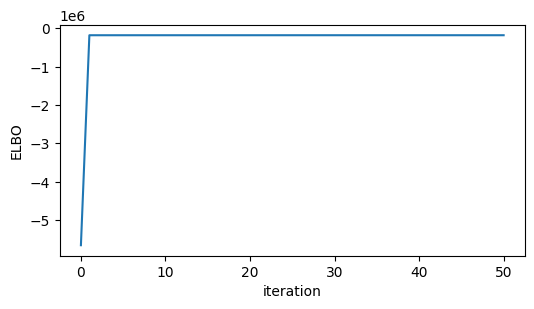

In [88]:
plt.figure(figsize=(6,3))
plt.plot(enc_elbo)
plt.xlabel('iteration')
plt.ylabel('ELBO')
pass

In [89]:
diff_lam = enc_lam[:,:,0] - enc_lam[:,:,1]

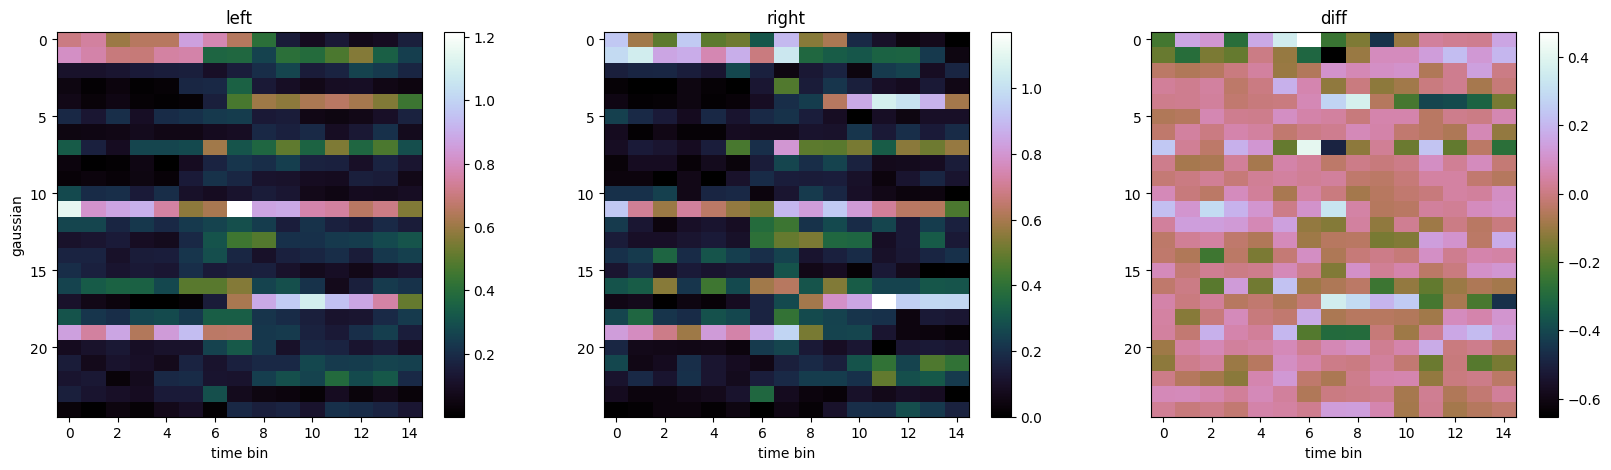

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(enc_lam[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title('left')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(enc_lam[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title('right')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(diff_lam, aspect='auto', cmap='cubehelix')
ax3.set_title('diff')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

In [91]:
# using observed lambda's
dec_r, dec_nu, dec_mu, dec_cov, dec_p, dec_elbo = cavi_dec(test_trials, 
                                      enc_mu, 
                                      enc_cov, 
                                      enc_lam, 
                                      test_trial_idx, 
                                      test_time_idx, 
                                      max_iter=50)

initial elbo: -1584077.96
iter: 1 elbo: -52773.06.
iter: 2 elbo: -52333.27.
iter: 3 elbo: -52206.37.
iter: 4 elbo: -52127.05.
iter: 5 elbo: -52072.28.
iter: 6 elbo: -52038.98.
iter: 7 elbo: -52017.86.
iter: 8 elbo: -51998.55.
iter: 9 elbo: -51978.90.
iter: 10 elbo: -51965.21.
iter: 11 elbo: -51951.88.
iter: 12 elbo: -51939.75.
iter: 13 elbo: -51928.38.
iter: 14 elbo: -51918.39.
iter: 15 elbo: -51910.67.
iter: 16 elbo: -51902.75.
iter: 17 elbo: -51892.18.
iter: 18 elbo: -51876.87.
iter: 19 elbo: -51857.10.
iter: 20 elbo: -51838.42.
iter: 21 elbo: -51824.67.
iter: 22 elbo: -51813.67.
iter: 23 elbo: -51804.21.
iter: 24 elbo: -51794.20.
iter: 25 elbo: -51785.11.
iter: 26 elbo: -51777.94.
iter: 27 elbo: -51772.03.
iter: 28 elbo: -51767.17.
iter: 29 elbo: -51762.96.
iter: 30 elbo: -51759.08.
iter: 31 elbo: -51755.30.
iter: 32 elbo: -51751.45.
iter: 33 elbo: -51747.57.
iter: 34 elbo: -51743.77.
iter: 35 elbo: -51740.02.
iter: 36 elbo: -51736.28.
iter: 37 elbo: -51732.63.
iter: 38 elbo: -51729

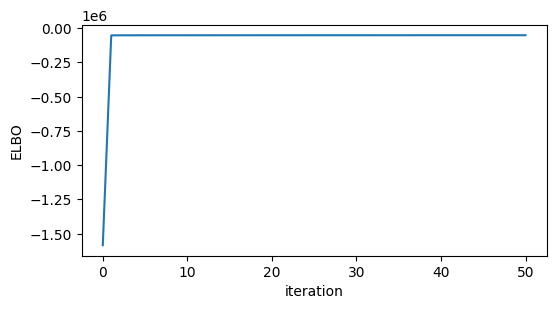

In [92]:
plt.figure(figsize=(6,3))
plt.plot(dec_elbo)
plt.xlabel('iteration')
plt.ylabel('ELBO')
pass

In [93]:
test_y

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0])

In [94]:
dec_nu

array([1.34129311e-09, 8.57687769e-09, 9.99999964e-01, 1.43338186e-12,
       2.36319822e-52, 1.72300680e-20, 2.27005292e-44, 2.48440301e-10,
       2.99812049e-12, 2.22946722e-12, 1.00000000e+00, 2.69537732e-21,
       9.43432979e-29, 2.81213165e-39, 3.68061614e-07, 1.63285978e-26,
       3.07774795e-31, 1.48738350e-36, 8.20266545e-24, 3.87368401e-37,
       3.08359532e-09, 3.75919608e-07, 3.56969204e-03, 7.30756781e-26,
       1.28773166e-47, 9.24014651e-29, 2.05218046e-22, 1.38643853e-07,
       1.68038261e-25, 1.00000000e+00, 1.00000000e+00, 9.99999998e-01,
       6.52871858e-41, 1.00000000e+00, 9.99999678e-01, 1.00000000e+00,
       9.99999996e-01, 8.69048012e-12, 9.98541247e-01, 9.99999809e-01,
       1.04249781e-09, 9.99999992e-01, 1.98475317e-61, 1.03401478e-23,
       9.99998973e-01, 1.00000000e+00, 9.99962667e-01, 4.47560837e-10,
       9.99999993e-01, 1.40936628e-13, 1.66063518e-17, 2.81333566e-32,
       4.39456669e-24])

In [95]:
np.array((dec_nu > .5) * 1., dtype=int)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0])

In [96]:
# (po) best auc = 0.898 (C = 50, t = 15, max_iter = 50)
# (po) best auc = 0.952 (C = 50, t = 10, max_iter = 50)
# (lp) best auc = 0.921 (C = 50, t = 15, max_iter = 50)
# (lp) best auc = 0.963 (C = 50, t = 10, max_iter = 50)
# (dg) best auc = 0.8  (C = 45, t = 10, max_iter = 50)
# (ca1) best auc = 0.821 (C = 30, t = 10, max_iter = 50)
# (ca1) best auc = 0.813 (C = 25, t = 10, max_iter = 50)
# (vis) best auc = 0.66 (C = 25, t = 10, max_iter = 50)
# (vis) best auc = 0.75 (C = 25, t = 15, max_iter = 50)

print(roc_auc_score(test_y, dec_nu))

0.7576923076923078


### sorted vs. good units

In [74]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)])
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]
spike_channels = unsorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
found 29 neurons in region vis ...
found 28 channels in region vis ...
sorted neural data shape: (265, 29, 30)
good sorted neural data shape: (265, 6, 30)


In [75]:
x_train = sorted_neural_data[train_idx].reshape(-1, sorted_neural_data.shape[1]*sorted_neural_data.shape[-1])
x_test = sorted_neural_data[test_idx].reshape(-1, sorted_neural_data.shape[1]*sorted_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, max_iter=1e4, tol = 0.01,
                            solver='liblinear').fit(x_train, train_y)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(test_y, preds)
auc = roc_auc_score(choices[test_idx], probs)

In [76]:
# (po) auc = 0.909
# (lp) auc = 0.965
# (dg) auc = 0.72
# (ca1) auc = 0.636
# (vis) auc = 0.66
print(auc)

0.6615384615384614


In [77]:
x_train = good_sorted_neural_data[train_idx].reshape(-1, good_sorted_neural_data.shape[1]*good_sorted_neural_data.shape[-1])
x_test = good_sorted_neural_data[test_idx].reshape(-1, good_sorted_neural_data.shape[1]*good_sorted_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, max_iter=1e4, tol = 0.01,
                            solver='liblinear').fit(x_train, train_y)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(test_y, preds)
auc = roc_auc_score(choices[test_idx], probs)

In [78]:
# (po) auc = 0.748
# (lp) auc = 0.963
# (dg) auc = 0.68
# (ca1) auc = 0.773
# (vis) auc = 0.69
print(auc)

0.698076923076923
